# Определение стоимости автомобилей

Техническое задание:

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

В ходе работы подготовлены и обработаны данные, проведён исследовательский анализ. С помощью моделей LGBMRegressor, дерево решений, случайного леса, линейной регрессии и градиентного бустинга CаtBoost предсказана стоимость автомобиля на основании его характериктик. С помощью GridSearchCV подобраны наилучшие параметры моделей. С помощью timeit проанализировано время обучения и предсказания каждой модели. Ключевая метрика, по которой сравнивались модели - MSE. В проекте использованы библиотеки pandas, matplotlib, numpy, seaborn, scipy, missingno, sklearn, lightgbm, catboost.

## Подготовка данных

Импортируем модули, которые нам понадобятся для дальнейшей работы.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from scipy import stats as st
!pip install missingno
import missingno as msno
import timeit
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split

Defaulting to user installation because normal site-packages is not writeable


Читаем базу данных.

In [ ]:
df = pd.read_csv('/datasets/autos.csv', sep= ',')
display(df.head().T)
df.info()

,0,1,2,3,4
DateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04,2016-03-31 17:25:20
Price,480,18300,9800,1500,3600
VehicleType,NaN,coupe,suv,small,small
RegistrationYear,1993,2011,2004,2001,2008
Gearbox,manual,manual,auto,manual,manual
Power,0,190,163,75,69
Model,golf,NaN,grand,golf,fabia
Kilometer,150000,125000,125000,150000,90000
RegistrationMonth,0,5,8,6,7
FuelType,petrol,gasoline,gasoline,petrol,gasoline


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Мы получили базу данных из 16 признаков. Всего в базе 354 369 записей. Данные содержат пропуски и выбросы. Названия столбцов соответствуют стандарту PEP8, но закодированы не в "snake case", исправим названия столбцов:

In [ ]:
result = [] 
for i in range(len(df.columns)):
    word = []
    for letter in df.columns[i]:
        if letter == letter.lower():
            word.append(letter)
        else:
            word.append('_')
            word.append(letter.lower())
        a = ''.join(word[1:])
    result.append(a)
df.columns = result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
date_crawled          354369 non-null object
price                 354369 non-null int64
vehicle_type          316879 non-null object
registration_year     354369 non-null int64
gearbox               334536 non-null object
power                 354369 non-null int64
model                 334664 non-null object
kilometer             354369 non-null int64
registration_month    354369 non-null int64
fuel_type             321474 non-null object
brand                 354369 non-null object
not_repaired          283215 non-null object
date_created          354369 non-null object
number_of_pictures    354369 non-null int64
postal_code           354369 non-null int64
last_seen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Данные содержат дубликаты:

In [ ]:
df.duplicated().sum()

4

Удалим дубликаты:

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Посмотрим на пропуски:

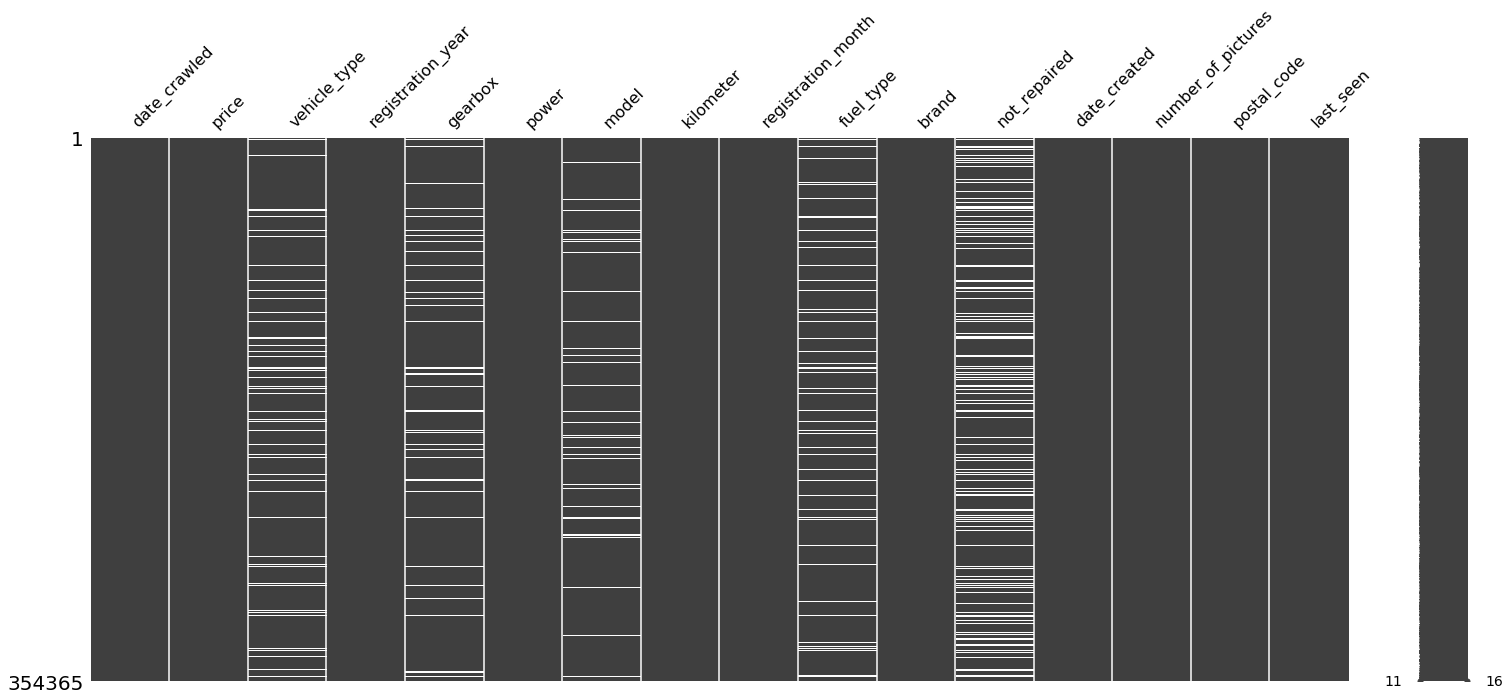

In [ ]:
msno.matrix(df.sort_values('date_crawled'))
plt.show()

Пропусков много, разберёмся с каждой переменной отдельно, заодно удалим выбросы.
Посмотрим на переменную цены:

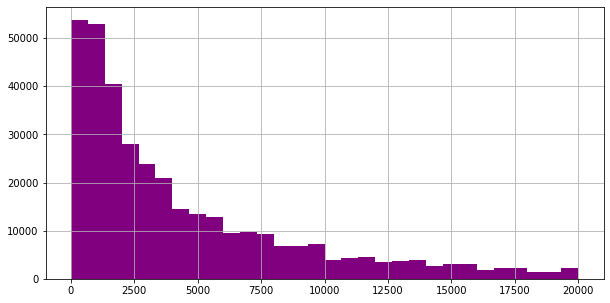

In [ ]:
df['price'].hist(bins=30, color = 'Purple', figsize = (10,5))
plt.show()

Распределение цены имеет длинный "хвост" справа, но убывает оно плавно. Максимальное значение - 20 тыс. евро. Посмотрим, сколько машин стоит 0 евро.

In [ ]:
len(df.query('price==0'))

10772

Примерно 3% машин стоит 0 евро. Такие цены подозрительны, стоит уточнить у поставщика данных природу таких объявлений. На первый взгляд причины низкой стоимости нет: они обладают обычными характеристиками, они не старше других машин в целом.

In [ ]:
print('Медиана года выпуска машин стоимостью 1 и более евро', df.query('price!=0')['registration_year'].median())
print('Медиана года выпуска машин стоимостью 0 евро', df.query('price==0')['registration_year'].median())

Медиана года выпуска машин стоимостью 1 и более евро 2003.0
Медиана года выпуска машин стоимостью 0 евро 2000.0


Если посмотреть на характер убывания частоты на начальном участке более пристально, мы увидим необычный пик в районе 0 евро. 

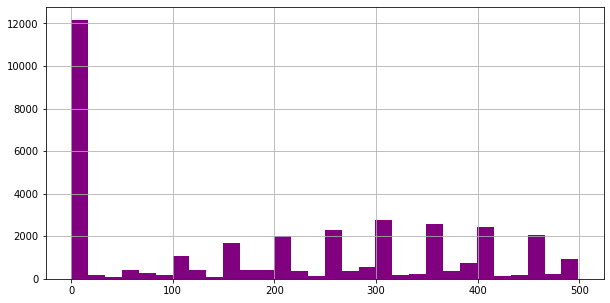

In [ ]:
df.query('price<500')['price'].hist(bins=30, color = 'Purple', figsize = (10,5))
plt.show()

Цены явно тяготеют к круглым значениям с шагом в 50 евро, такова природа воприятия цен потребителями. Т.к. убывание цены идёт не плавно и у нас нет данных, объясняющих нулевую стоимость машин, это могут быть объявления в процессе заполнения, ошибочно заполненные и некорректные объявления, поэтому мы примем решение удалить машины дешевле 50 евро. Оставить пропуски мы не можем, т.к. одно из требований проекта - сравнить результаты с простыми моделями, для которых пропуски критичны. Восстанавливать значения цены также некорректно, т.к. это главный целевой признак.

In [ ]:
df = df.query('price >= 50')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341942 entries, 0 to 354368
Data columns (total 16 columns):
date_crawled          341942 non-null object
price                 341942 non-null int64
vehicle_type          308963 non-null object
registration_year     341942 non-null int64
gearbox               325278 non-null object
power                 341942 non-null int64
model                 324779 non-null object
kilometer             341942 non-null int64
registration_month    341942 non-null int64
fuel_type             313229 non-null object
brand                 341942 non-null object
not_repaired          277079 non-null object
date_created          341942 non-null object
number_of_pictures    341942 non-null int64
postal_code           341942 non-null int64
last_seen             341942 non-null object
dtypes: int64(7), object(9)
memory usage: 44.3+ MB


Посмотрим на типы машин:

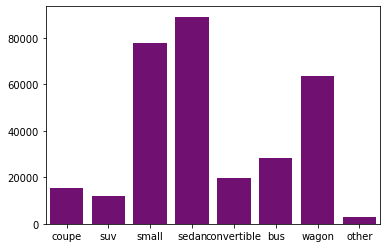

32979

In [ ]:
sb.barplot(
    x = df.vehicle_type.unique(),
    y = [(df['vehicle_type']==i).sum() for i in df.vehicle_type.unique()],
    color = 'Purple')
plt.show()
df.vehicle_type.isna().sum()

Пропусков много, почти десятая часть базы. Можно попытаться восстановить тип кузова по модели и бренду, однако тип кузова не определяется моделью неоднозначно. Поэтому присвоим пропускам текстовое значение "missing".

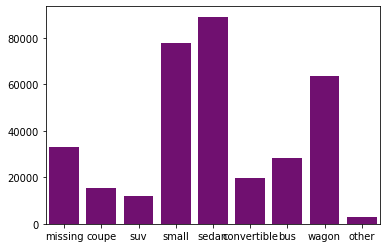

0

In [ ]:
df.vehicle_type = df.vehicle_type.fillna('missing')
sb.barplot(
    x = df.vehicle_type.unique(),
    y = [(df['vehicle_type']==i).sum() for i in df.vehicle_type.unique()],
    color = 'Purple')
plt.show()
df.vehicle_type.isna().sum()

Далее переменная года регистрации автомобиля. В ней нет пропусков, но есть выбросы, которые мы удалим, т.к. их крайне немного:

In [ ]:
df['registration_year'].describe()

count    341942.000000
mean       2004.079774
std          77.070996
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [ ]:
np.percentile(df['registration_year'], np.arange(0,0.1,0.01))

array([1000.  , 1319.41, 1910.  , 1932.  , 1942.  , 1951.  , 1954.  ,
       1956.  , 1958.  , 1959.  ])

In [ ]:
np.percentile(df['registration_year'], np.arange(99.9,100,0.01))

array([2018., 2018., 2018., 2018., 2018., 2018., 2018., 2018., 3000.,
       6000.])

Удалим машины "старше" 1910 года и "младше" 2016 года выпуска, т.к. наша база - от 2016 года, а восстановить год выпуска авто будет рискованно, т.к. эта переменная будет сильно влиять на стоимость.

In [ ]:
df = df.query('registration_year >= 1910 and registration_year <= 2016')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328192 entries, 0 to 354368
Data columns (total 16 columns):
date_crawled          328192 non-null object
price                 328192 non-null int64
vehicle_type          328192 non-null object
registration_year     328192 non-null int64
gearbox               313257 non-null object
power                 328192 non-null int64
model                 312895 non-null object
kilometer             328192 non-null int64
registration_month    328192 non-null int64
fuel_type             304730 non-null object
brand                 328192 non-null object
not_repaired          269272 non-null object
date_created          328192 non-null object
number_of_pictures    328192 non-null int64
postal_code           328192 non-null int64
last_seen             328192 non-null object
dtypes: int64(7), object(9)
memory usage: 42.6+ MB


Таких машин оказалось примерно 150 штук.

В переменной коробки передач также заполним пропуски на "missing":

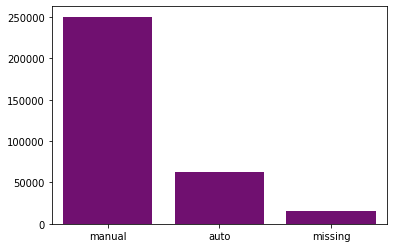

0

In [ ]:
df.gearbox = df.gearbox.fillna('missing')
sb.barplot(
    x = df.gearbox.unique(),
    y = [(df['gearbox']==i).sum() for i in df.gearbox.unique()],
    color = 'Purple')
plt.show()
df.gearbox.isna().sum()

Далее распределение мощности двигателя. Пропусков здесь нет, но критические минимальные и слишком высокие значения есть:

In [ ]:
df['power'].describe()

count    328192.000000
mean        112.135055
std         185.103679
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [ ]:
np.percentile(df['power'], np.arange(0,15,1))

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 27., 45., 50.,
       54., 54.])

In [ ]:
np.percentile(df['power'], np.arange(99.5,100,0.01))

array([  334.        ,   340.        ,   340.        ,   340.        ,
         340.        ,   340.        ,   340.        ,   340.7787    ,
         343.        ,   344.        ,   344.        ,   344.        ,
         345.        ,   347.        ,   349.        ,   349.        ,
         350.        ,   354.        ,   354.        ,   355.        ,
         360.        ,   363.        ,   367.        ,   367.        ,
         370.7034    ,   385.        ,   387.        ,   387.        ,
         394.        ,   400.        ,   400.        ,   420.        ,
         435.        ,   442.2259    ,   450.        ,   450.        ,
         459.5326    ,   479.86870001,   500.        ,   518.9798    ,
         600.        ,   738.90910001,   999.4472    ,  1100.7989    ,
        1360.1708    ,  1545.42150002,  1782.4472    ,  2006.0854    ,
        5833.81360004, 10746.18000016])

Отсутствуют данные (стоит 0) у 11% базы, и это много, чтобы удалить данный массив. Однако мы в ходе исследования мы выяснили, что мощность машины сильно зависит от её типа:

In [ ]:
df.groupby('vehicle_type')['power'].mean()

vehicle_type
bus            111.993951
convertible    132.415510
coupe          154.209972
missing         62.987012
other           98.150573
sedan          127.857657
small           68.787715
suv            154.920952
wagon          134.215038
Name: power, dtype: float64

In [ ]:
from itertools import combinations

rating_combinations = [i for i in combinations(df['vehicle_type'].unique(), 2)]
num_comb = len(rating_combinations)

alpha = 0.05

for a, b in rating_combinations:
    a_data = df.loc[df['vehicle_type'] == a, 'power']
    b_data = df.loc[df['vehicle_type'] == b, 'power']
    _, p_value = st.ttest_ind(a_data, b_data, equal_var=False)
    
    print(p_value)
    if p_value > alpha / num_comb:
        print(f'Между {a} и {b} нет значимых отличий')
    else:
        print(f'Между {a} и {b} ЕСТЬ значимые отличия')

0.0
Между missing и coupe ЕСТЬ значимые отличия
0.0
Между missing и suv ЕСТЬ значимые отличия
3.1693841618716616e-05
Между missing и small ЕСТЬ значимые отличия
0.0
Между missing и sedan ЕСТЬ значимые отличия
0.0
Между missing и convertible ЕСТЬ значимые отличия
2.325177504290978e-206
Между missing и bus ЕСТЬ значимые отличия
0.0
Между missing и wagon ЕСТЬ значимые отличия
2.7118741613430657e-08
Между missing и other ЕСТЬ значимые отличия
0.706419668513222
Между coupe и suv нет значимых отличий
0.0
Между coupe и small ЕСТЬ значимые отличия
6.200690917060457e-47
Между coupe и sedan ЕСТЬ значимые отличия
1.8061124806549483e-24
Между coupe и convertible ЕСТЬ значимые отличия
1.2332068135818887e-101
Между coupe и bus ЕСТЬ значимые отличия
1.2292175160104327e-24
Между coupe и wagon ЕСТЬ значимые отличия
3.561947918341197e-18
Между coupe и other ЕСТЬ значимые отличия
0.0
Между suv и small ЕСТЬ значимые отличия
1.82139687819873e-170
Между suv и sedan ЕСТЬ значимые отличия
4.494125351344025e-5

Заменим мощность машин, у которых указан 0 или значение больше 1000 на медиану мощности данного типа кузова:

In [ ]:
df.power = df.query('power > 0 and power <= 1000').power
df.power = df.power.fillna(df.groupby('vehicle_type')['power'].transform('median'))
df.power.isna().sum()

0

В переменной модели машины также заполним пропуски на "missing". Моделей много, группы наполнены по-разному, кроме заполнения пропусков данную переменную скорректировать сложно.

In [ ]:
df.model = df.model.fillna('missing')
df.model.isna().sum()

0

Далее переменная пробега авто:

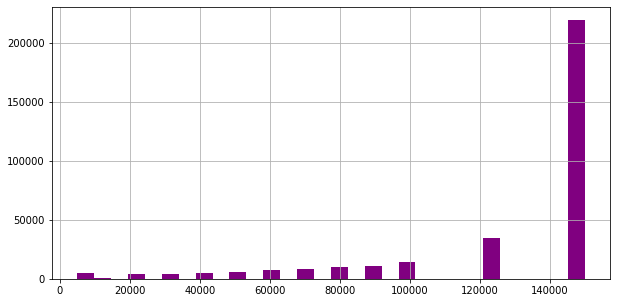

In [ ]:
df['kilometer'].hist(bins=30, color = 'Purple', figsize = (10,5))
plt.show()

In [ ]:
df.kilometer.isna().sum()

0

Пропусков нет, нулевых значений, тоже, но большая часть базы имеет константное зачение пробега:

In [ ]:
df.kilometer.value_counts()

150000    219576
125000     34338
100000     13931
90000      11023
80000       9590
70000       8255
60000       7204
50000       5985
40000       4757
5000        4613
30000       4209
20000       3664
10000       1047
Name: kilometer, dtype: int64

150 000 км - некритично для машины. Однако доля таких машин в базе кажется странной: на auto.ru количество машин с пробегом до 150 000 км на 13.02.22 г. составляет 2/3 активной базы. В анализируемой базе таких машин 1/3. Также, переменная дискретна: она принимает всего 13 видов значений, что делает её категориальной. Создадим новую переменную, которую будем использовать в моделях.

In [ ]:
kilometer_map = {
    5000: 'up to 5K km',
    10000: '5-10K km',
    20000: '10-20K km',
    30000: '20-30K km',
    40000: '30-40K km',
    50000: '40-50K km',
    60000: '50-60K km',
    70000: '60-70K km',
    80000: '70-80K km',
    90000: '80-90K km',
    100000: '90-100K km',
    125000: '100-125K km',
    150000: '125K km and more'
}
df['kilometer_cat'] = df['kilometer'].map(kilometer_map)
df

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,kilometer_cat
0,2016-03-24 11:52:17,480,missing,1993,manual,100.0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,125K km and more
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,missing,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,100-125K km
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,100-125K km
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,125K km and more
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,80-90K km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000,manual,116.0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23,125K km and more
354365,2016-03-14 17:48:27,2200,missing,2005,missing,100.0,missing,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52,10-20K km
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101.0,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12,100-125K km
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102.0,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26,125K km and more


Переменную месяца регистрации автомобиля мы в прогноз стоимости автомобиля включать не будем, т.к. на цену влияет год, но никак не месяц выпуска авто.

Далее переменная типа топлива. Здесь пропусков немного, включим их в категорию "missing".

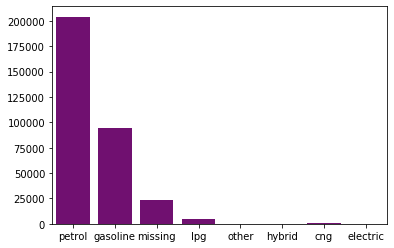

0

In [ ]:
df.fuel_type = df.fuel_type.fillna('missing')
sb.barplot(
    x = df.fuel_type.unique(),
    y = [(df['fuel_type']==i).sum() for i in df.fuel_type.unique()],
    color = 'Purple')
plt.show()
df.fuel_type.isna().sum()

In [ ]:
df.fuel_type.value_counts()

petrol      204073
gasoline     94660
missing      23462
lpg           5012
cng            530
hybrid         219
other          150
electric        86
Name: fuel_type, dtype: int64

Категории электрокаров и гибридов объединим ввиду малонаполненности и схожести по сути. Также объединим lpg и cng, т.к. и то, и другое газ. Нам придётся объединить и petrol с gasoline, т.к. и то, и другое - бензин, называемый по-разному в разных странах Европы (в Британии прежде всего).

In [ ]:
fuel_map = {
    'petrol': 'gasoline',
    'gasoline': 'gasoline',
    'missing': 'missing',
    'lpg': 'gas',
    'cng': 'gas',
    'hybrid': 'electric',
    'electric': 'electric',
    'other': 'missing'    
}
df['fuel_retyped'] = df['fuel_type'].map(fuel_map)
df

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,kilometer_cat,fuel_retyped
0,2016-03-24 11:52:17,480,missing,1993,manual,100.0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,125K km and more,gasoline
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,missing,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,100-125K km,gasoline
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,100-125K km,gasoline
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,125K km and more,gasoline
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21,80-90K km,gasoline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000,manual,116.0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23,125K km and more,gasoline
354365,2016-03-14 17:48:27,2200,missing,2005,missing,100.0,missing,20000,1,missing,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52,10-20K km,missing
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101.0,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12,100-125K km,gasoline
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102.0,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26,125K km and more,gasoline


В переменной бренда нет ни пропусков, ни дублирующихся названий, оставим, как есть.

In [ ]:
print(df.brand.isna().sum())
df.brand.value_counts()

0


volkswagen        70508
opel              36502
bmw               34555
mercedes_benz     30213
audi              27525
ford              23409
renault           16367
peugeot           10388
fiat               8844
seat               6336
skoda              5294
mazda              5239
smart              4946
citroen            4783
nissan             4604
toyota             4385
hyundai            3390
mini               3056
volvo              3045
mitsubishi         2804
sonstige_autos     2599
honda              2582
kia                2303
suzuki             2198
alfa_romeo         2140
chevrolet          1653
chrysler           1318
dacia               863
daihatsu            747
subaru              711
porsche             700
jeep                630
land_rover          526
daewoo              502
saab                501
jaguar              483
trabant             470
lancia              433
rover               433
lada                207
Name: brand, dtype: int64

В переменной ремонта машины заполним пропуски на "missing":

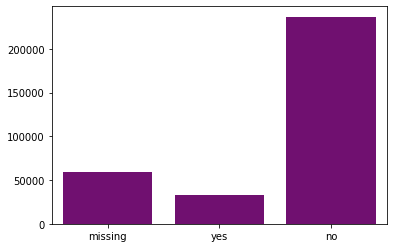

0

In [ ]:
df.not_repaired = df.not_repaired.fillna('missing')
sb.barplot(
    x = df.not_repaired.unique(),
    y = [(df['not_repaired']==i).sum() for i in df.not_repaired.unique()],
    color = 'Purple')
plt.show()
df.not_repaired.isna().sum()

Далее дата создания объявления, она нам тоже не пригодится для прогнозирования цены. Затем переменная количества фотографий, однако она пуста, поэтому мы её не будем использовать.

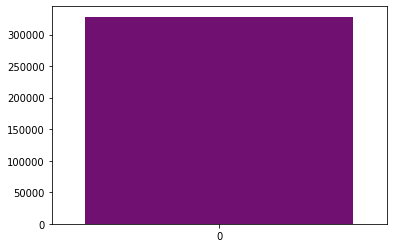

0

In [ ]:
sb.barplot(
    x = df.number_of_pictures.unique(),
    y = [(df['number_of_pictures']==i).sum() for i in df.number_of_pictures.unique()],
    color = 'Purple')
plt.show()
df.number_of_pictures.isna().sum()

Переменные дат в данной базе в модели участвовать не будут, т.к. все объявления зарегистрированы в течение одного месяца, в этом же месяце они собраны в базу, примерно в этом же месяце пользователь последний раз заходил на сайт.

Ещё одна переменная, которую мы исключим - почтовый индекс. Известно, что все данные из одной страны (почтовый код в едином формате и информация из внешних источников), а дополнительной базы, которая бы помогла ранжировать почтовые индексы по какому-либо принципу, у нас нет.

Разделим данные на тренировочную и тестовую выборку.

In [ ]:
X = df.drop(['price',
             'date_crawled',
             'registration_month',
             'date_created',
             'number_of_pictures',
             'postal_code',
             'last_seen',
             'fuel_type',
             'kilometer'], axis=1)
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(328192, 9) (328192,)
(262553, 9) (262553,)
(65639, 9) (65639,)


Для работы простых моделей нам необходимо перевести категориальные признаки в дихотомические:

In [ ]:
X_ohe = pd.get_dummies(X, drop_first=True)
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=23)
print(X_ohe.shape, y.shape)
print(X_train_ohe.shape, y_train.shape)
print(X_test_ohe.shape, y_test.shape)

(328192, 318) (328192,)
(262553, 318) (262553,)
(65639, 318) (65639,)


Нормируем два метрических признака - год выпуска авто и мощность - для более корректной работы моделей.

In [ ]:
scaler = StandardScaler()

X_train[['registration_year', 'power']] = scaler.fit_transform(X_train[['registration_year', 'power']])
X_test[['registration_year', 'power']] = scaler.fit_transform(X_test[['registration_year', 'power']])

X_train_ohe[['registration_year', 'power']] = scaler.fit_transform(X_train_ohe[['registration_year', 'power']])
X_test_ohe[['registration_year', 'power']] = scaler.fit_transform(X_test_ohe[['registration_year', 'power']])

Данные готовы для построения модели. Наиболее существенное преобразование - удаление машин дешевле 50 евро и замена нулевой мощности на среднее для данного типа кузова.

## Обучение моделей

### Модель линейной регрессии

In [ ]:
start_time = timeit.default_timer()

model = LinearRegression()
model.fit(X_train_ohe, y_train)

elapsed_fitting = timeit.default_timer() - start_time



start_time = timeit.default_timer()

predictions = model.predict(X_test_ohe)

elapsed_prediction = timeit.default_timer() - start_time



current_model = pd.DataFrame({'Model': ['Linear Regression'],
              'learning time, sec': [elapsed_fitting],
              'prediction time, sec': [elapsed_prediction],
              'RMSE, euro': [mean_squared_error(y_test, predictions)**0.5]})
all_models = current_model.merge(current_model, how = 'outer')
all_models

,Model,"learning time, sec","prediction time, sec","RMSE, euro"
0,Linear Regression,27.96236,0.130547,2651.855799


### Модель случайного леса

In [ ]:
start_time = timeit.default_timer()

model = RandomForestRegressor(random_state = 23)
model.fit(X_train_ohe, y_train)

elapsed_fitting = timeit.default_timer() - start_time



start_time = timeit.default_timer()

predictions = model.predict(X_test_ohe)

elapsed_prediction = timeit.default_timer() - start_time



current_model = pd.DataFrame({'Model': ['Random Forest'],
              'learning time, sec': [elapsed_fitting],
              'prediction time, sec': [elapsed_prediction],
              'RMSE, euro': [mean_squared_error(y_test, predictions)**0.5]})
all_models = all_models.merge(current_model, how = 'outer')
all_models

,Model,"learning time, sec","prediction time, sec","RMSE, euro"
0,Linear Regression,27.962360,0.130547,2651.855799
1,Random Forest,73.742923,0.542571,1650.873298


### Модель дерева решений

In [ ]:
start_time = timeit.default_timer()

model = DecisionTreeRegressor(random_state = 23)
model.fit(X_train_ohe, y_train)

elapsed_fitting = timeit.default_timer() - start_time



start_time = timeit.default_timer()

predictions = model.predict(X_test_ohe)

elapsed_prediction = timeit.default_timer() - start_time



current_model = pd.DataFrame({'Model': ['Decision Tree'],
              'learning time, sec': [elapsed_fitting],
              'prediction time, sec': [elapsed_prediction],
              'RMSE, euro': [mean_squared_error(y_test, predictions)**0.5]})
all_models = all_models.merge(current_model, how = 'outer')
all_models

,Model,"learning time, sec","prediction time, sec","RMSE, euro"
0,Linear Regression,27.962360,0.130547,2651.855799
1,Random Forest,73.742923,0.542571,1650.873298
2,Decision Tree,11.532035,0.162689,1932.501056


### Градиентный бустинг Catboost

In [ ]:
start_time = timeit.default_timer()

cat_features = ['vehicle_type', 'gearbox', 'model',
                'brand', 'not_repaired', 'not_repaired', 'kilometer_cat', 'fuel_retyped']
model = CatBoostRegressor(loss_function="RMSE", iterations=90)
model.fit(X_train, y_train, cat_features=cat_features, verbose=10)

elapsed_fitting = timeit.default_timer() - start_time



start_time = timeit.default_timer()

predictions = model.predict(X_test)

elapsed_prediction = timeit.default_timer() - start_time



current_model = pd.DataFrame({'Model': ['Catboost'],
              'learning time, sec': [elapsed_fitting],
              'prediction time, sec': [elapsed_prediction],
              'RMSE, euro': [mean_squared_error(y_test, predictions)**0.5]})
all_models = all_models.merge(current_model, how = 'outer')
all_models

0:	learn: 4455.8585866	total: 639ms	remaining: 56.8s
10:	learn: 3728.9981382	total: 3.84s	remaining: 27.6s
20:	learn: 3225.3827374	total: 6.93s	remaining: 22.8s
30:	learn: 2871.5545617	total: 9.93s	remaining: 18.9s
40:	learn: 2615.1936183	total: 12.9s	remaining: 15.5s
50:	learn: 2428.4042873	total: 16.2s	remaining: 12.4s
60:	learn: 2299.8754006	total: 19.1s	remaining: 9.09s
70:	learn: 2204.3346345	total: 22.1s	remaining: 5.91s
80:	learn: 2124.8885077	total: 25.1s	remaining: 2.79s
89:	learn: 2072.3293140	total: 27.8s	remaining: 0us


,Model,"learning time, sec","prediction time, sec","RMSE, euro"
0,Linear Regression,27.962360,0.130547,2651.855799
1,Random Forest,73.742923,0.542571,1650.873298
2,Decision Tree,11.532035,0.162689,1932.501056
3,Catboost,30.726629,0.151101,2073.914951


### Градиентный бустинг LightGBM

In [ ]:
start_time = timeit.default_timer()

model = LGBMRegressor(random_state=23)
model.fit(X_train_ohe, y_train, eval_set=[(X_test_ohe, y_test),], eval_metric=["rmse"])

elapsed_fitting = timeit.default_timer() - start_time



start_time = timeit.default_timer()

predictions = model.predict(X_test_ohe)

elapsed_prediction = timeit.default_timer() - start_time



current_model = pd.DataFrame({'Model': ['LightGBM'],
              'learning time, sec': [elapsed_fitting],
              'prediction time, sec': [elapsed_prediction],
              'RMSE, euro': [mean_squared_error(y_test, predictions)**0.5]})
all_models = all_models.merge(current_model, how = 'outer')
all_models

[1]	valid_0's rmse: 4226.09	valid_0's l2: 1.78599e+07
[2]	valid_0's rmse: 3937.54	valid_0's l2: 1.55042e+07
[3]	valid_0's rmse: 3685.59	valid_0's l2: 1.35836e+07
[4]	valid_0's rmse: 3468.63	valid_0's l2: 1.20314e+07
[5]	valid_0's rmse: 3278.25	valid_0's l2: 1.07469e+07
[6]	valid_0's rmse: 3112.15	valid_0's l2: 9.68546e+06
[7]	valid_0's rmse: 2964.4	valid_0's l2: 8.78764e+06
[8]	valid_0's rmse: 2835.35	valid_0's l2: 8.03918e+06
[9]	valid_0's rmse: 2725.78	valid_0's l2: 7.4299e+06
[10]	valid_0's rmse: 2628.35	valid_0's l2: 6.90822e+06
[11]	valid_0's rmse: 2540.03	valid_0's l2: 6.45178e+06
[12]	valid_0's rmse: 2464.09	valid_0's l2: 6.07175e+06
[13]	valid_0's rmse: 2396.85	valid_0's l2: 5.74487e+06
[14]	valid_0's rmse: 2339.04	valid_0's l2: 5.4711e+06
[15]	valid_0's rmse: 2289.25	valid_0's l2: 5.24067e+06
[16]	valid_0's rmse: 2243.69	valid_0's l2: 5.03414e+06
[17]	valid_0's rmse: 2203.54	valid_0's l2: 4.85558e+06
[18]	valid_0's rmse: 2167.83	valid_0's l2: 4.69949e+06
[19]	valid_0's rmse: 2

,Model,"learning time, sec","prediction time, sec","RMSE, euro"
0,Linear Regression,27.962360,0.130547,2651.855799
1,Random Forest,73.742923,0.542571,1650.873298
2,Decision Tree,11.532035,0.162689,1932.501056
3,Catboost,30.726629,0.151101,2073.914951
4,LightGBM,14.986327,0.995269,1718.700250


## Анализ моделей

Наилучшая скорость работы - у дерева решений, 12 секунд. Схожие параметры у градиентного бустинга LightGBM. Минимальным RMSE обладает Случайный лест (1651 евро), но и LightGBM показывает корень среднеквадратической ошибки на уровне 1718 евро.

Улучшим параметры градиентного бустинга LightGBM с помощью GridSearch:

In [ ]:
parameters = {'num_leaves': [30, 50],
              'min_data_in_leaf': [15, 20, 25],
              'max_depth': [5, 10]}
LGBM = LGBMRegressor(random_state=23)

Grid_LGBM = GridSearchCV(estimator=LGBM, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_LGBM.fit(X_train_ohe, y_train, eval_set=[(X_test_ohe, y_test),], eval_metric=["rmse"])

[1]	valid_0's rmse: 4231.55	valid_0's l2: 1.7906e+07
[2]	valid_0's rmse: 3957.55	valid_0's l2: 1.56622e+07
[3]	valid_0's rmse: 3714.53	valid_0's l2: 1.37977e+07
[4]	valid_0's rmse: 3497.89	valid_0's l2: 1.22352e+07
[5]	valid_0's rmse: 3312.2	valid_0's l2: 1.09706e+07
[6]	valid_0's rmse: 3146.81	valid_0's l2: 9.90241e+06
[7]	valid_0's rmse: 3001.39	valid_0's l2: 9.00834e+06
[8]	valid_0's rmse: 2875.4	valid_0's l2: 8.26794e+06
[9]	valid_0's rmse: 2764.97	valid_0's l2: 7.64503e+06
[10]	valid_0's rmse: 2670.93	valid_0's l2: 7.13387e+06
[11]	valid_0's rmse: 2587.03	valid_0's l2: 6.69272e+06
[12]	valid_0's rmse: 2513.28	valid_0's l2: 6.31659e+06
[13]	valid_0's rmse: 2449.13	valid_0's l2: 5.99822e+06
[14]	valid_0's rmse: 2393.4	valid_0's l2: 5.72836e+06
[15]	valid_0's rmse: 2345.6	valid_0's l2: 5.50184e+06
[16]	valid_0's rmse: 2299.87	valid_0's l2: 5.28938e+06
[17]	valid_0's rmse: 2261.57	valid_0's l2: 5.11468e+06
[18]	valid_0's rmse: 2226.6	valid_0's l2: 4.95775e+06
[19]	valid_0's rmse: 2195

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=23,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'min_data_in_leaf': [15, 20, 25],
                         'num_leaves': [30, 50]},
             pre_dispatch='2*n_jobs', refit

In [ ]:
Grid_LGBM.best_params_

{'max_depth': 10, 'min_data_in_leaf': 15, 'num_leaves': 50}

Подставим полученные значения в модель и рассчитаем итоговые показатели среднеквадратической ошибки и скорости обучения.

In [ ]:
start_time = timeit.default_timer()

model = LGBMRegressor(random_state=23, max_depth=10, num_leaves=15, min_data_in_leaf=50)
model.fit(X_train_ohe, y_train, eval_set=[(X_test_ohe, y_test),], eval_metric=["rmse"])

elapsed_fitting = timeit.default_timer() - start_time



start_time = timeit.default_timer()

predictions = model.predict(X_test_ohe)

elapsed_prediction = timeit.default_timer() - start_time



current_model = pd.DataFrame({'Model': ['LightGBM tuned'],
              'learning time, sec': [elapsed_fitting],
              'prediction time, sec': [elapsed_prediction],
              'RMSE, euro': [mean_squared_error(y_test, predictions)**0.5]})
all_models = all_models.merge(current_model, how = 'outer')
all_models

[1]	valid_0's rmse: 4249.28	valid_0's l2: 1.80564e+07
[2]	valid_0's rmse: 3985.55	valid_0's l2: 1.58846e+07
[3]	valid_0's rmse: 3754.8	valid_0's l2: 1.40985e+07
[4]	valid_0's rmse: 3549.82	valid_0's l2: 1.26012e+07
[5]	valid_0's rmse: 3376.45	valid_0's l2: 1.14004e+07
[6]	valid_0's rmse: 3216.75	valid_0's l2: 1.03475e+07
[7]	valid_0's rmse: 3079.26	valid_0's l2: 9.48184e+06
[8]	valid_0's rmse: 2956.94	valid_0's l2: 8.7435e+06
[9]	valid_0's rmse: 2847.83	valid_0's l2: 8.11015e+06
[10]	valid_0's rmse: 2756.24	valid_0's l2: 7.59686e+06
[11]	valid_0's rmse: 2672.48	valid_0's l2: 7.14213e+06
[12]	valid_0's rmse: 2599.55	valid_0's l2: 6.75768e+06
[13]	valid_0's rmse: 2533.3	valid_0's l2: 6.41763e+06
[14]	valid_0's rmse: 2471.27	valid_0's l2: 6.10718e+06
[15]	valid_0's rmse: 2421.99	valid_0's l2: 5.86604e+06
[16]	valid_0's rmse: 2380.3	valid_0's l2: 5.66585e+06
[17]	valid_0's rmse: 2338.96	valid_0's l2: 5.47073e+06
[18]	valid_0's rmse: 2304.22	valid_0's l2: 5.30945e+06
[19]	valid_0's rmse: 22

,Model,"learning time, sec","prediction time, sec","RMSE, euro"
0,Linear Regression,27.962360,0.130547,2651.855799
1,Random Forest,73.742923,0.542571,1650.873298
2,Decision Tree,11.532035,0.162689,1932.501056
3,Catboost,30.726629,0.151101,2073.914951
4,LightGBM,14.986327,0.995269,1718.700250
5,LightGBM tuned,14.821785,0.884255,1793.161723


Изменение параметров не привело к улучшению показателей модели. Попробуем настроить градиентный бустинг Catboost.

In [ ]:
parameters = {'iterations': [100, 120],
              'depth': [10, 15],
              'learning_rate': [0.04, 0.08]}
CBR = CatBoostRegressor(loss_function="RMSE")

Grid_CBR = GridSearchCV(estimator=CBR, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBR.fit(X_train, y_train, cat_features=cat_features, verbose=10)
Grid_CBR.best_params_

0:	learn: 4417.8111456	total: 290ms	remaining: 28.7s
10:	learn: 3428.4072059	total: 3.08s	remaining: 24.9s
20:	learn: 2810.2744279	total: 5.58s	remaining: 21s
30:	learn: 2429.7874894	total: 8.28s	remaining: 18.4s
40:	learn: 2199.3939231	total: 11.2s	remaining: 16.1s
50:	learn: 2048.4843236	total: 13.8s	remaining: 13.2s
60:	learn: 1952.3323639	total: 16.4s	remaining: 10.5s
70:	learn: 1885.8437191	total: 19s	remaining: 7.78s
80:	learn: 1844.2028636	total: 21.7s	remaining: 5.1s
90:	learn: 1815.8673031	total: 24.3s	remaining: 2.4s
99:	learn: 1793.0107787	total: 26.6s	remaining: 0us
0:	learn: 4413.8077323	total: 226ms	remaining: 22.4s
10:	learn: 3420.4420803	total: 2.92s	remaining: 23.7s
20:	learn: 2816.7187468	total: 5.53s	remaining: 20.8s
30:	learn: 2449.0274841	total: 8.21s	remaining: 18.3s
40:	learn: 2216.5352602	total: 10.9s	remaining: 15.7s
50:	learn: 2061.9225338	total: 13.4s	remaining: 12.9s
60:	learn: 1970.9464936	total: 16.1s	remaining: 10.3s
70:	learn: 1904.7702066	total: 18.7s	r

{'depth': 15, 'iterations': 120, 'learning_rate': 0.08}

In [ ]:
start_time = timeit.default_timer()

model = CatBoostRegressor(loss_function="RMSE", depth=15, learning_rate=0.08, iterations=120)
model.fit(X_train, y_train, cat_features=cat_features, verbose=10)

elapsed_fitting = timeit.default_timer() - start_time



start_time = timeit.default_timer()

predictions = model.predict(X_test)

elapsed_prediction = timeit.default_timer() - start_time



current_model = pd.DataFrame({'Model': ['Catboost tuned'],
              'learning time, sec': [elapsed_fitting],
              'prediction time, sec': [elapsed_prediction],
              'RMSE, euro': [mean_squared_error(y_test, predictions)**0.5]})
all_models = all_models.merge(current_model, how = 'outer')
all_models

0:	learn: 4279.3425173	total: 1.58s	remaining: 3m 8s
10:	learn: 2678.8165564	total: 17.2s	remaining: 2m 50s
20:	learn: 2058.4193565	total: 33.1s	remaining: 2m 35s
30:	learn: 1822.5220361	total: 48.6s	remaining: 2m 19s
40:	learn: 1711.4392494	total: 1m 4s	remaining: 2m 3s
50:	learn: 1652.0353929	total: 1m 19s	remaining: 1m 47s
60:	learn: 1611.5908448	total: 1m 35s	remaining: 1m 32s
70:	learn: 1584.6054886	total: 1m 51s	remaining: 1m 16s
80:	learn: 1563.7883927	total: 2m 6s	remaining: 1m 1s
90:	learn: 1544.9089337	total: 2m 23s	remaining: 45.6s
100:	learn: 1528.6729272	total: 2m 38s	remaining: 29.9s
110:	learn: 1514.3130615	total: 2m 54s	remaining: 14.1s
119:	learn: 1502.1893843	total: 3m 7s	remaining: 0us


,Model,"learning time, sec","prediction time, sec","RMSE, euro"
0,Linear Regression,27.962360,0.130547,2651.855799
1,Random Forest,73.742923,0.542571,1650.873298
2,Decision Tree,11.532035,0.162689,1932.501056
3,Catboost,30.726629,0.151101,2073.914951
4,LightGBM,14.986327,0.995269,1718.700250
5,LightGBM tuned,14.821785,0.884255,1793.161723
6,Catboost tuned,190.594275,0.333270,1637.482782


Градиентный бустинг CatBoost дал хорошее снижение RMSE до 1637 евро, однако длительность обучения - 3 минуты - вряд ли устроит заказчика. Посмотрим, что будет, если убрать незначимые признаки:

In [ ]:
model.feature_importances_

array([12.43960082, 33.37795244,  3.23603887, 20.17215337,  5.22599649,
       13.90312978,  4.84749615,  6.50535272,  0.29227936])

In [ ]:
X_train

,vehicle_type,registration_year,gearbox,power,model,brand,not_repaired,kilometer_cat,fuel_retyped
135246,small,-0.669341,manual,-0.156082,3er,bmw,no,125K km and more,gasoline
274681,sedan,0.056825,manual,0.582736,3er,bmw,no,125K km and more,gasoline
260826,small,-0.088408,manual,-1.122227,c1,citroen,missing,125K km and more,gasoline
52599,missing,0.347292,auto,2.893907,7er,bmw,yes,125K km and more,missing
46397,small,-0.814574,manual,-0.553906,civic,honda,no,125K km and more,gasoline
...,...,...,...,...,...,...,...,...,...
218990,small,0.637759,manual,-0.516018,swift,suzuki,no,100-125K km,gasoline
293502,convertible,-0.378875,auto,0.184911,slk,mercedes_benz,missing,70-80K km,gasoline
241019,sedan,0.347292,auto,-0.193970,a_klasse,mercedes_benz,no,125K km and more,gasoline
293005,wagon,1.073459,manual,-0.269746,ibiza,seat,no,100-125K km,gasoline


Менее 1% вкладывает в изменение итоговой цены тип топлива. Также до 5% значимость типа коробки передач и наличие информации о пройденном ремонте. Удалим эти 3 признака и посмотрим на изменение модели CatBoost:

In [ ]:
start_time = timeit.default_timer()
cat_features = ['vehicle_type', 'model', 'brand', 'kilometer_cat']
model = CatBoostRegressor(loss_function="RMSE", depth=15, learning_rate=0.08, iterations=120)
model.fit(X_train.drop(['fuel_retyped', 'gearbox', 'not_repaired'], axis=1), y_train, cat_features=cat_features, verbose=10)

elapsed_fitting = timeit.default_timer() - start_time



start_time = timeit.default_timer()

predictions = model.predict(X_test.drop(['fuel_retyped', 'gearbox', 'not_repaired'], axis=1))

elapsed_prediction = timeit.default_timer() - start_time



current_model = pd.DataFrame({'Model': ['Catboost desreased'],
              'learning time, sec': [elapsed_fitting],
              'prediction time, sec': [elapsed_prediction],
              'RMSE, euro': [mean_squared_error(y_test, predictions)**0.5]})
all_models = all_models.merge(current_model, how = 'outer')
all_models

0:	learn: 4282.0190388	total: 1.24s	remaining: 2m 27s
10:	learn: 2712.5273849	total: 14.1s	remaining: 2m 19s
20:	learn: 2118.4619982	total: 26.8s	remaining: 2m 6s
30:	learn: 1896.9087148	total: 39.2s	remaining: 1m 52s
40:	learn: 1792.2647090	total: 52.1s	remaining: 1m 40s
50:	learn: 1735.5196484	total: 1m 5s	remaining: 1m 28s
60:	learn: 1703.6648923	total: 1m 18s	remaining: 1m 15s
70:	learn: 1683.4570858	total: 1m 30s	remaining: 1m 2s
80:	learn: 1666.6964653	total: 1m 42s	remaining: 49.4s
90:	learn: 1645.6480774	total: 1m 54s	remaining: 36.6s
100:	learn: 1628.8938948	total: 2m 6s	remaining: 23.8s
110:	learn: 1612.8463863	total: 2m 19s	remaining: 11.3s
119:	learn: 1600.5274592	total: 2m 30s	remaining: 0us


,Model,"learning time, sec","prediction time, sec","RMSE, euro"
0,Linear Regression,27.962360,0.130547,2651.855799
1,Random Forest,73.742923,0.542571,1650.873298
2,Decision Tree,11.532035,0.162689,1932.501056
3,Catboost,30.726629,0.151101,2073.914951
4,LightGBM,14.986327,0.995269,1718.700250
5,LightGBM tuned,14.821785,0.884255,1793.161723
6,Catboost tuned,190.594275,0.333270,1637.482782
7,Catboost desreased,153.138955,0.190466,1708.249025


Модель стала проще (быстрее) обучаться, RMSE не понизился, но повысился не существенно, однако длительность обучения сократилась недостаточно. Можно ещё настроить гиперпараметры модели и попробовать добавить вычислительных ресурсов, чтобы сократить длительность обучения.

## Вывод

Мы создали модель предсказания стоимости автомобилей для сервиса "Не бит, не крашен". Наилучший вариант - градиентный бустинг  LightGBM, с помощью которого удалось добиться ключевой метрики RMSE на уровне 1719 евро. С подобранными параметрами модель обучается 15 секунд.